## 비음수 행렬 분해(NMF)

![Alt text](http://cfile24.uf.tistory.com/image/990F9B405A3923AF21FB8F)
- NMF
  - 0 또는 양수의 주성분과 계수값만을 생성
  - 주성분과 계수의 가중치 합은 음수가 아니므로 원 데이터의 특성에 음수가 없어야 함.
- NMF 활용 데이터
  - 음성/악기 오디오 데이터
  - 여러 악기 또는 음성이 섞여 있는 데이터에서 각 원본 성분들을 구분할 수 있음
- PCA vs. NMF
  - PCA
    - 음수 성분이나 계수가 만드는 효과의 이해가 어려움. 
    - 실제로 부호에는 아무런 규칙이 없음
  - NMF
    - 상대적으로 PCA보다 해석하기 쉬움.
    - 모든 주성분 사이에 원본 데이터의 특질을 더 많이 포함하는 중요도 차이가 없음 --> 즉 모든 주성분은 동등하게 중요
    - 무작위 초기화 --> 난수 생성 초기값에 따라 결과가 달라짐
    

##### Applying NMF to synthetic data
- 원본 데이터 확인
  - 원본 데이터의 각 성분이 양수인지 확인하는 작업 필요
  - 각 데이터가 원점 (0,0)에서 상대적으로 어디에 놓여 있는가가 중요.
  - 즉, 원점 (0,0)에서 데이터가 가는 방향을 추출한 것으로 음수미포함 성분을 이해 가능<br/><br/>  

- NMF 알고리즘
  - $X$: 원본 입력 데이터
  - $W$: 변환 행렬
  - $H$: 주성분
  - the approximation of $X$ by $X \simeq WH$ is achieved by minimizing the error function $$\min_{W,H}|| X-WH ||_{F},~subject~to~W\geq 0, H\geq 0$$.
  - 다음과 같은 L2 노름, Frobenius Norm의 제곱인 $$\frac{1}{2} \sum_{i,j}(X_{ij}-WH_{ij})^2$$을 목적함수로 하여 '좌표 하강법'으로 최소화함

In [1]:
%matplotlib inline
import sys 
sys.path.append('..')
from preamble import *

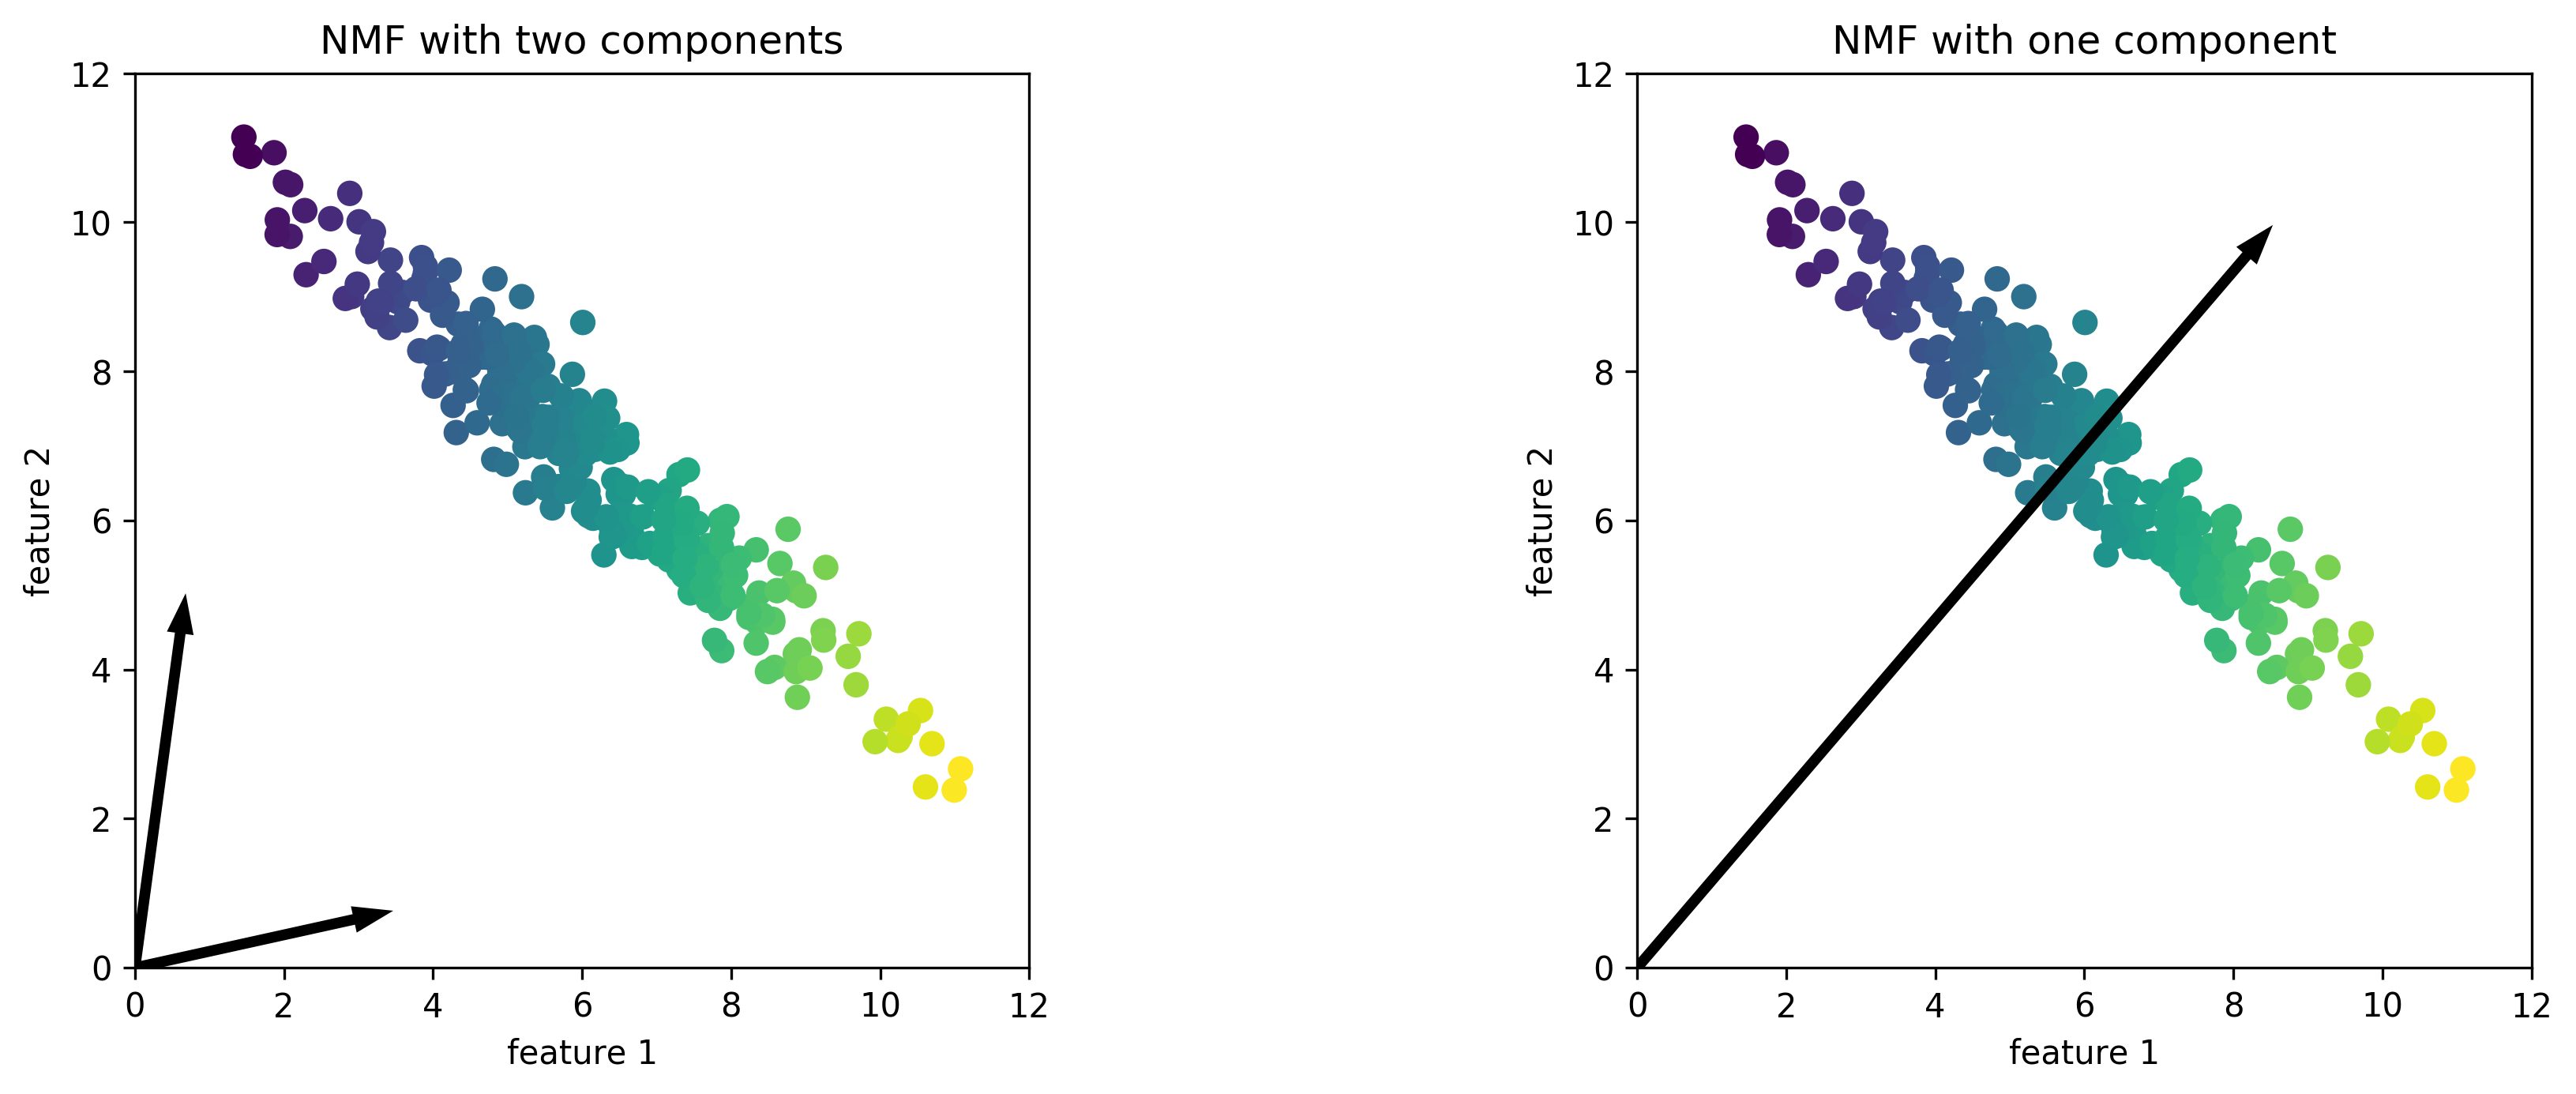

In [2]:
mglearn.plots.plot_nmf_illustration()

#### 얼굴 이미지에 NMF 적용하기

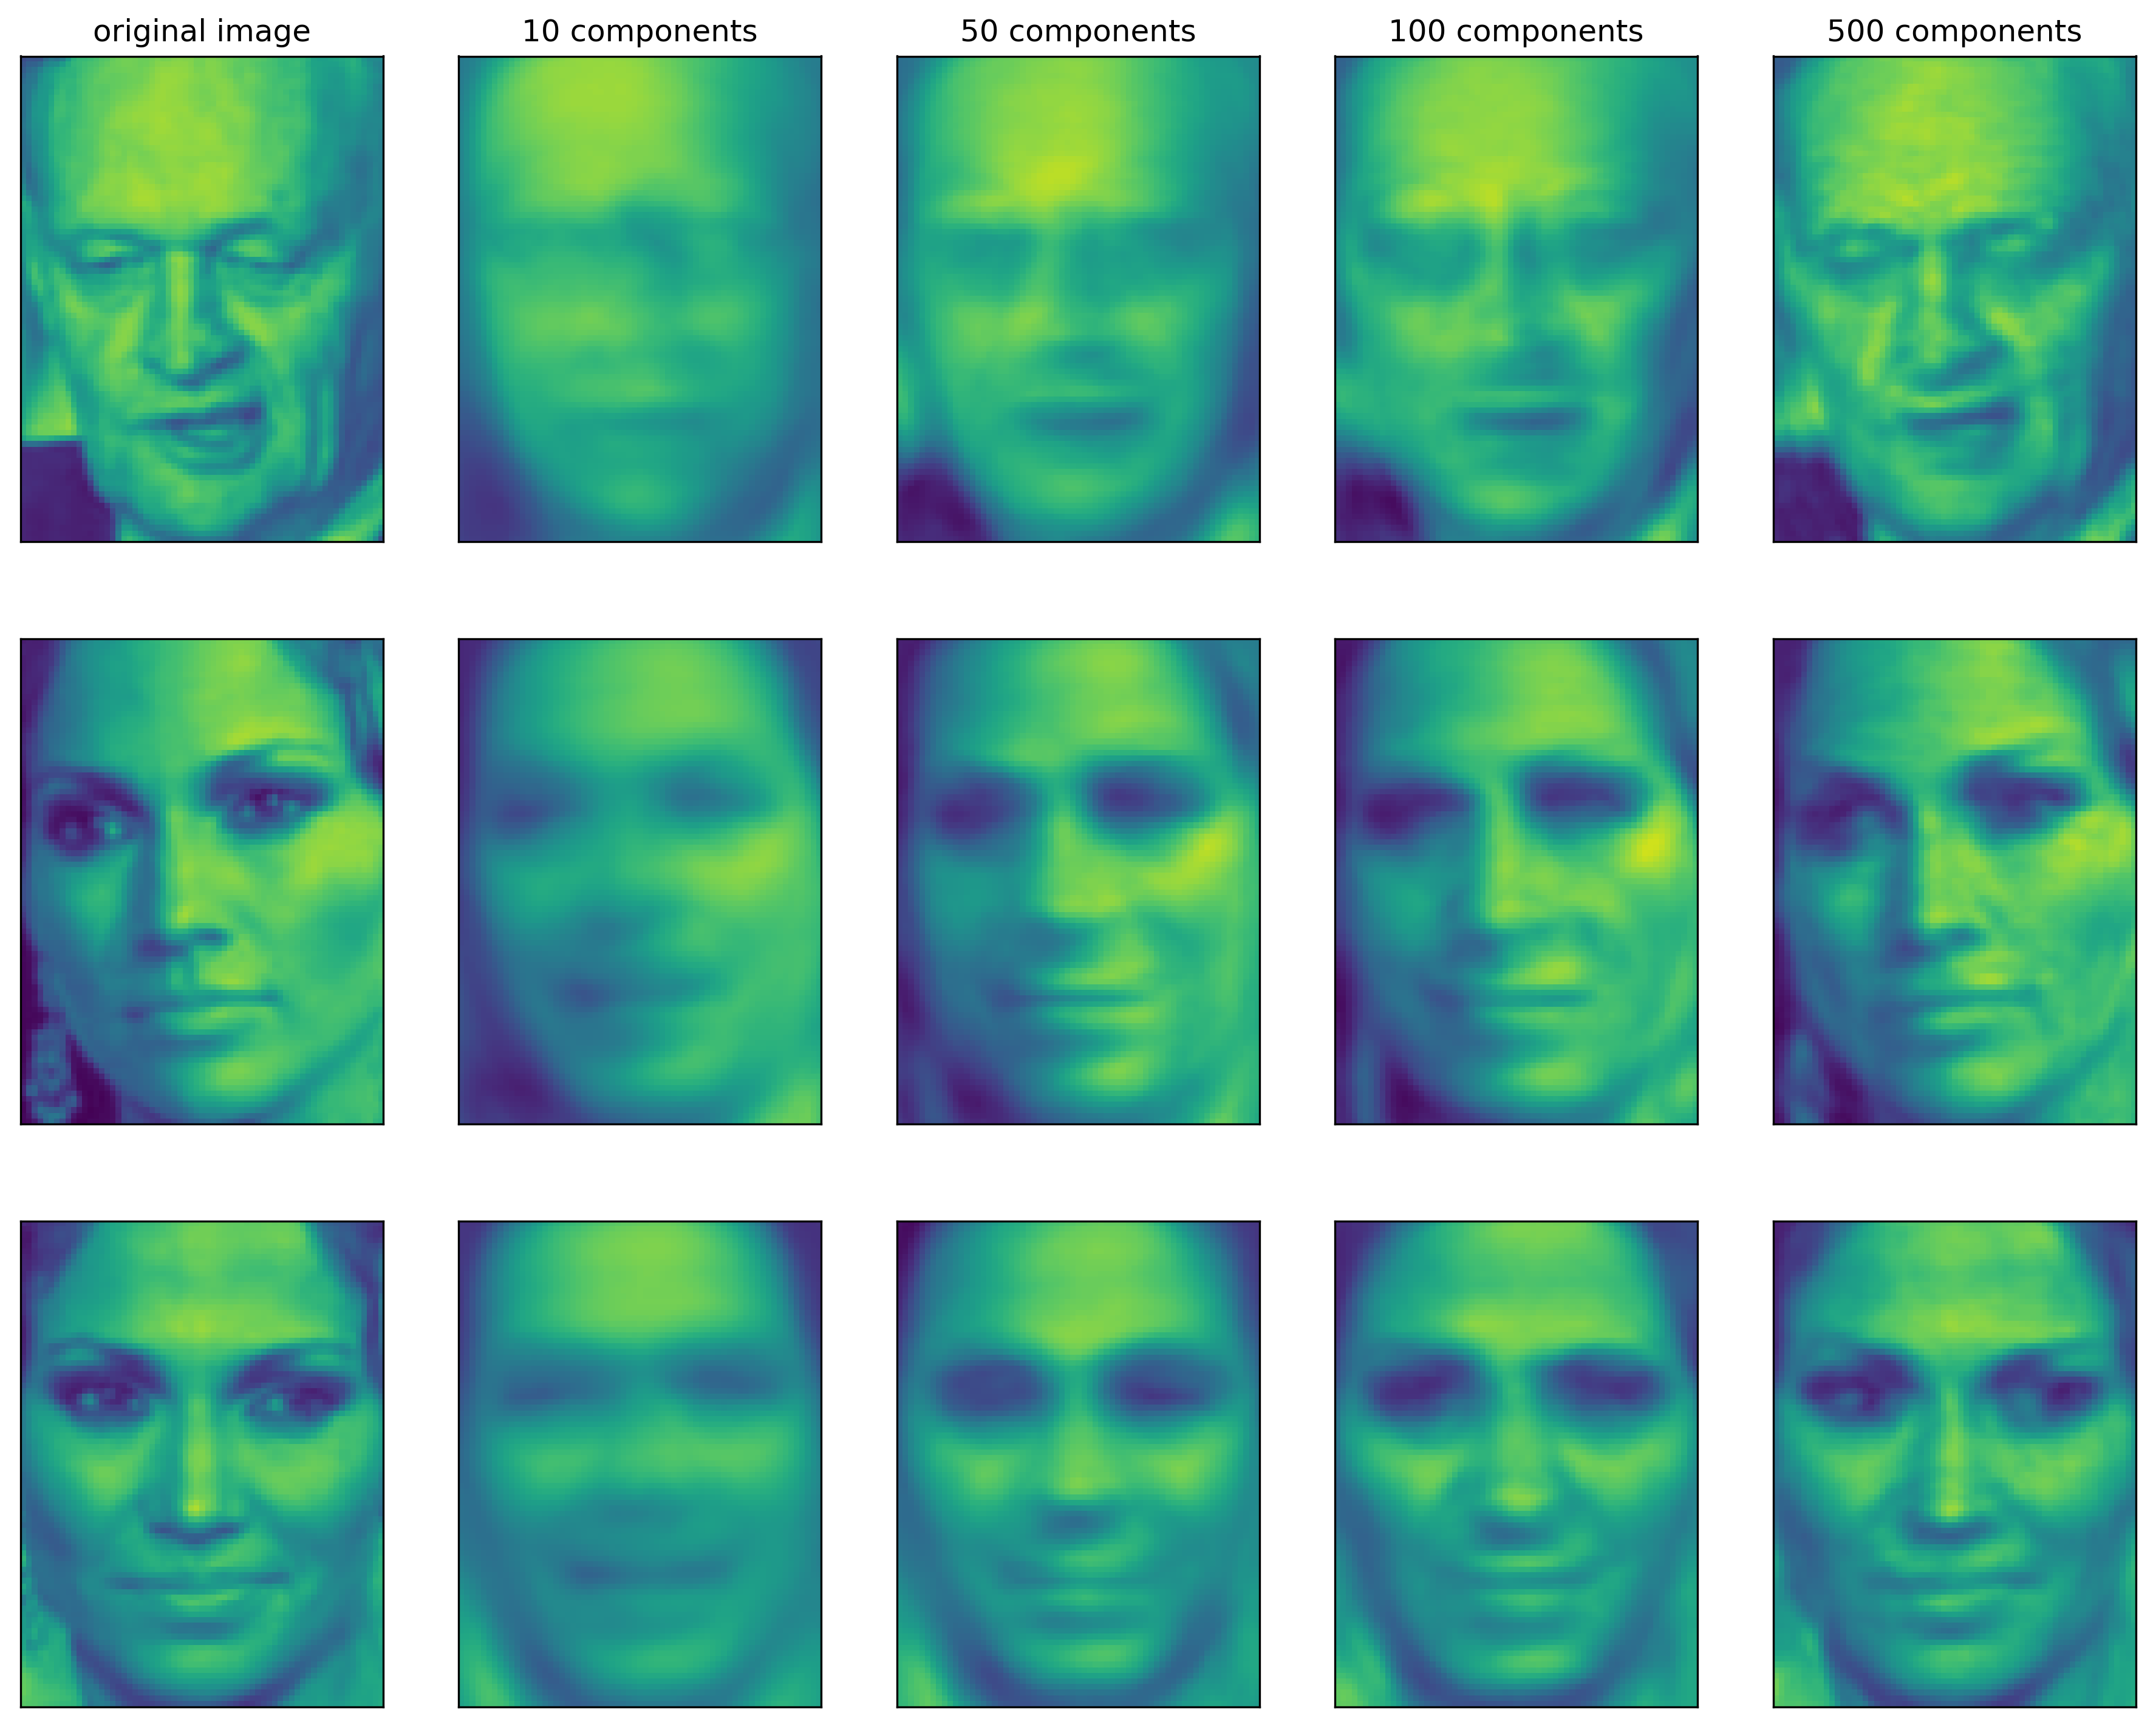

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_lfw_people

people = fetch_lfw_people(min_faces_per_person=20, resize=0.7)
image_shape = people.images[0].shape
mask = np.zeros(people.target.shape, dtype=np.bool)

for target in np.unique(people.target):
#     print("np.where(people.target == {0}):\n{1}".format(target, np.where(people.target == target)))
    mask[np.where(people.target == target)[0][:50]] = 1
#     print()

X_people = people.data[mask]
y_people = people.target[mask]

# scale the grey-scale values to be between 0 and 1
# instead of 0 and 255 for better numeric stability:
X_people = X_people / 255.
X_train, X_test, y_train, y_test = train_test_split(X_people, y_people, stratify=y_people, random_state=0)

mglearn.plots.plot_nmf_faces(X_train, X_test, image_shape)

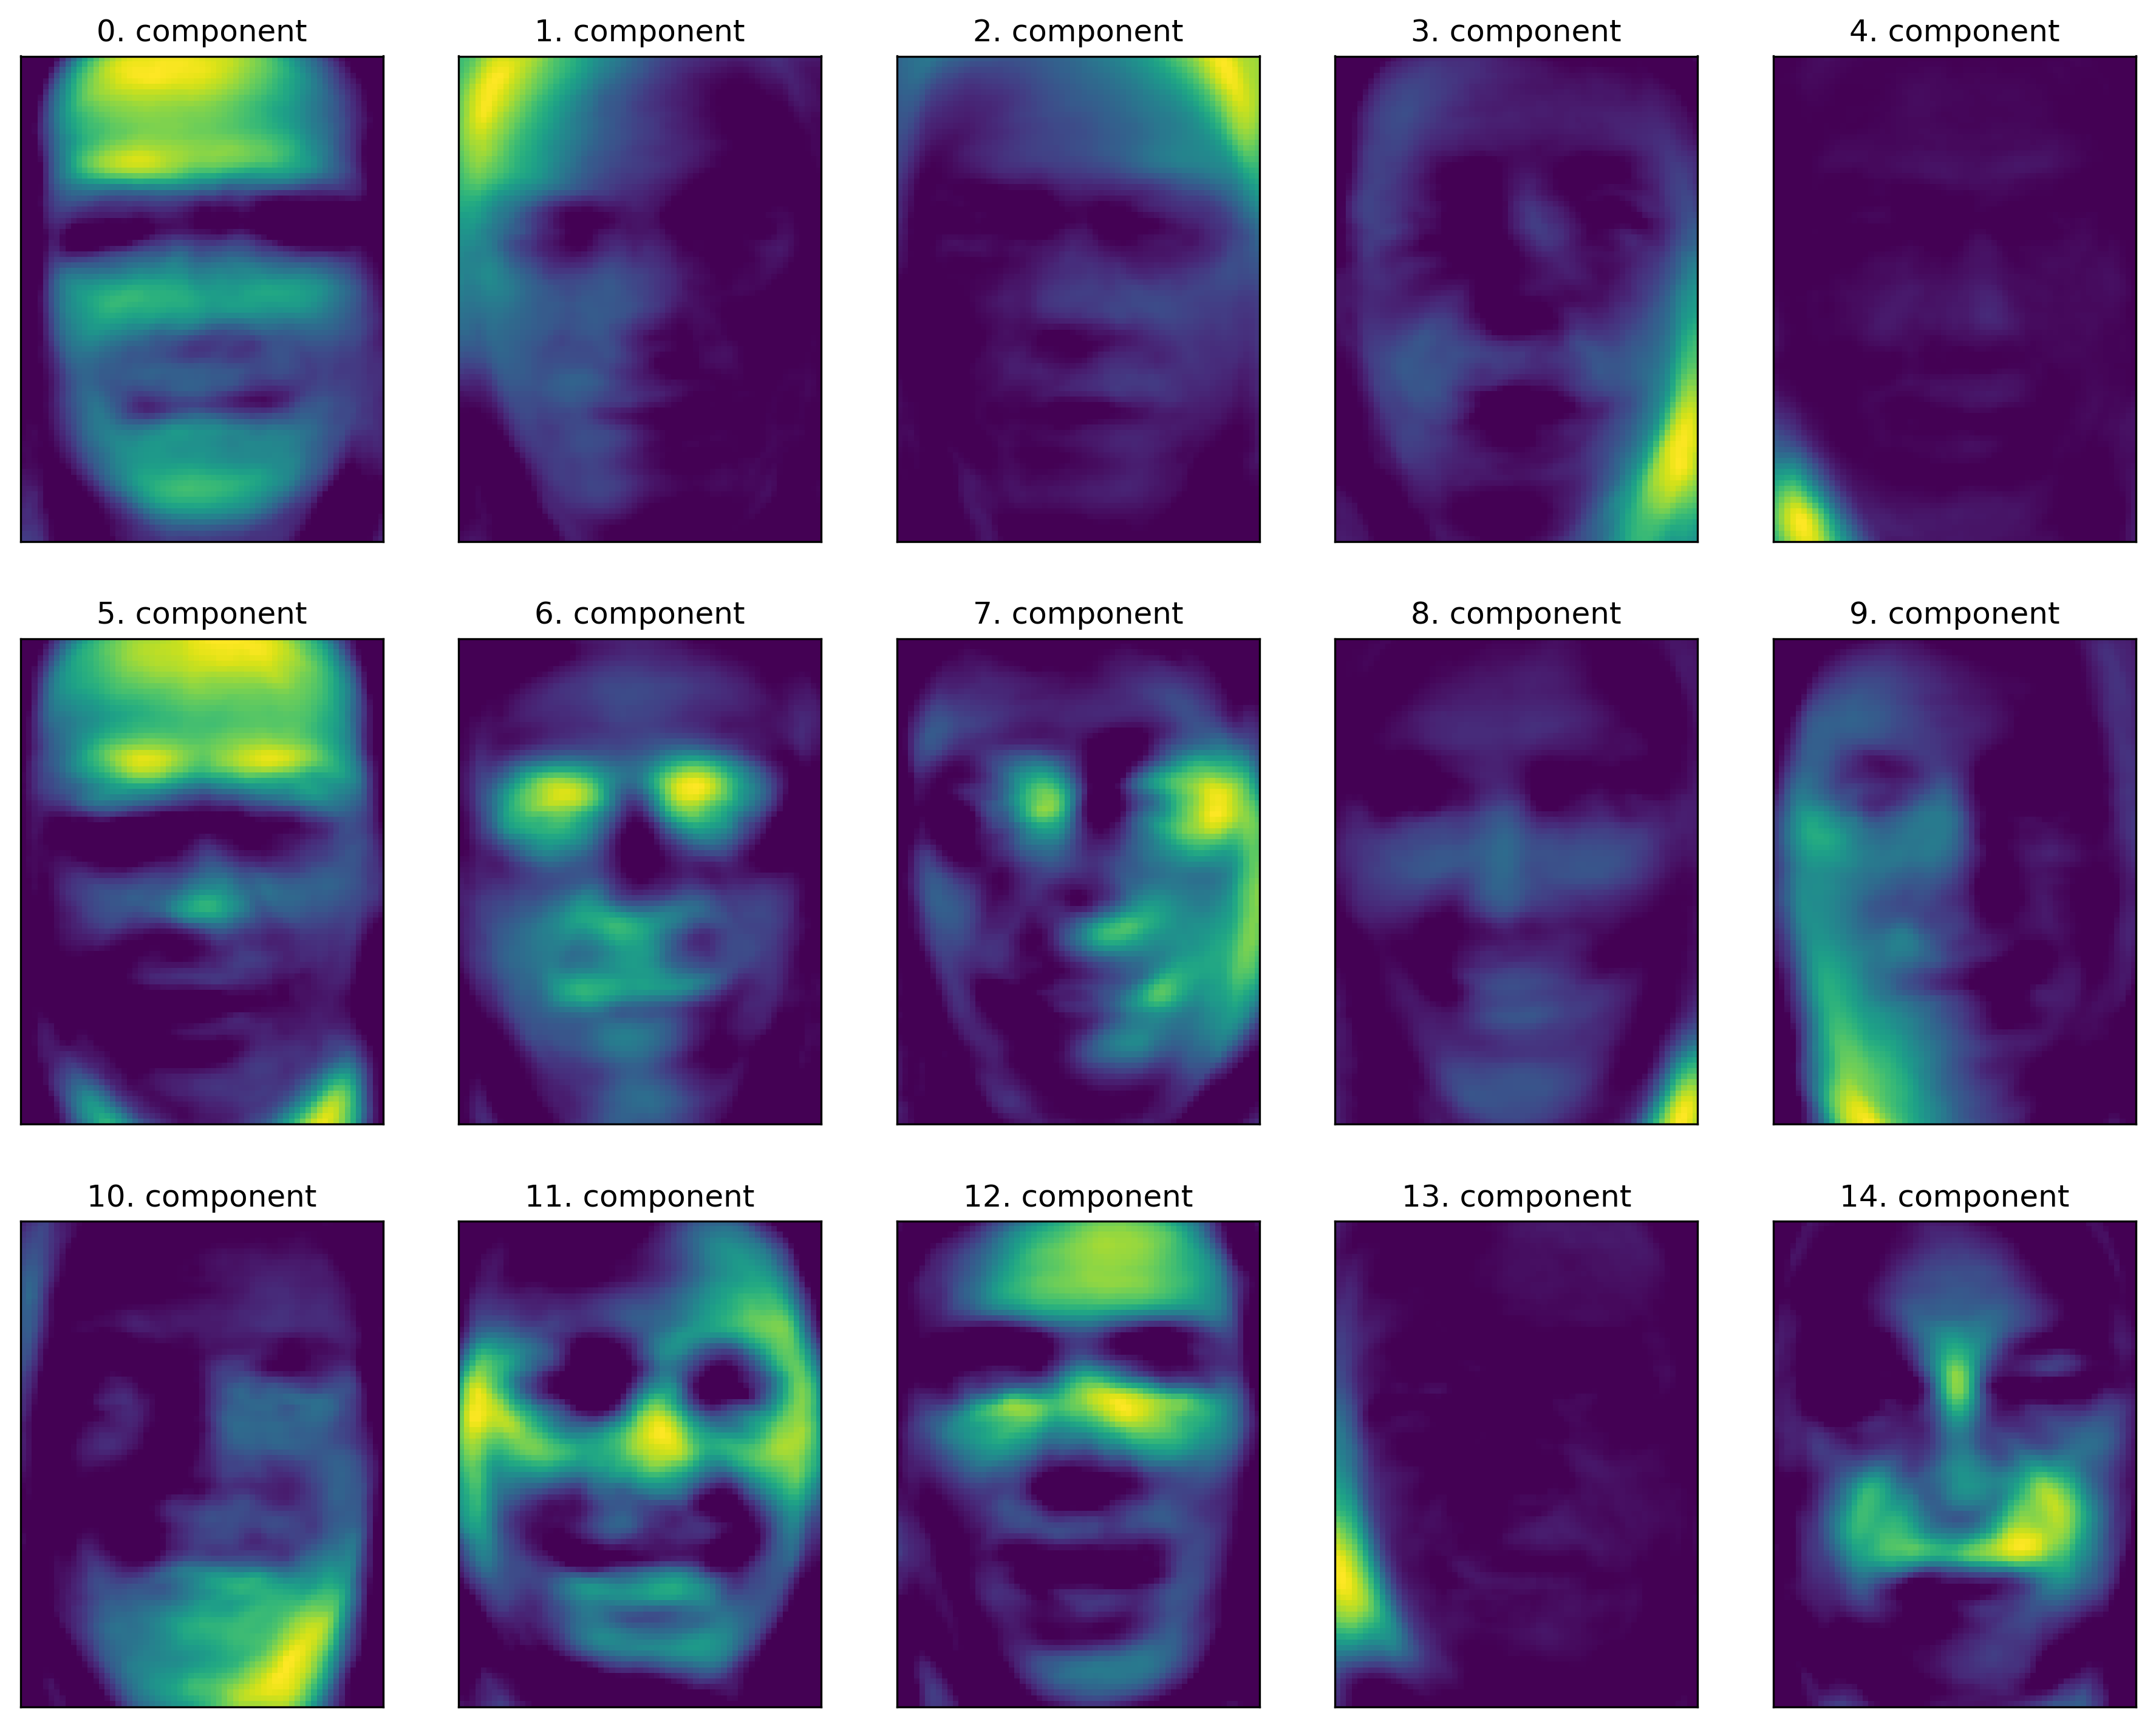

In [14]:
from sklearn.decomposition import NMF
nmf = NMF(n_components=15, random_state=0)
nmf.fit(X_train)
X_train_nmf = nmf.transform(X_train)
X_test_nmf = nmf.transform(X_test)

fig, axes = plt.subplots(3, 5, figsize=(15, 12), subplot_kw={'xticks': (), 'yticks': ()})
for i, (component, ax) in enumerate(zip(nmf.components_, axes.ravel())):
    ax.imshow(component.reshape(image_shape))
    ax.set_title("{}. component".format(i))

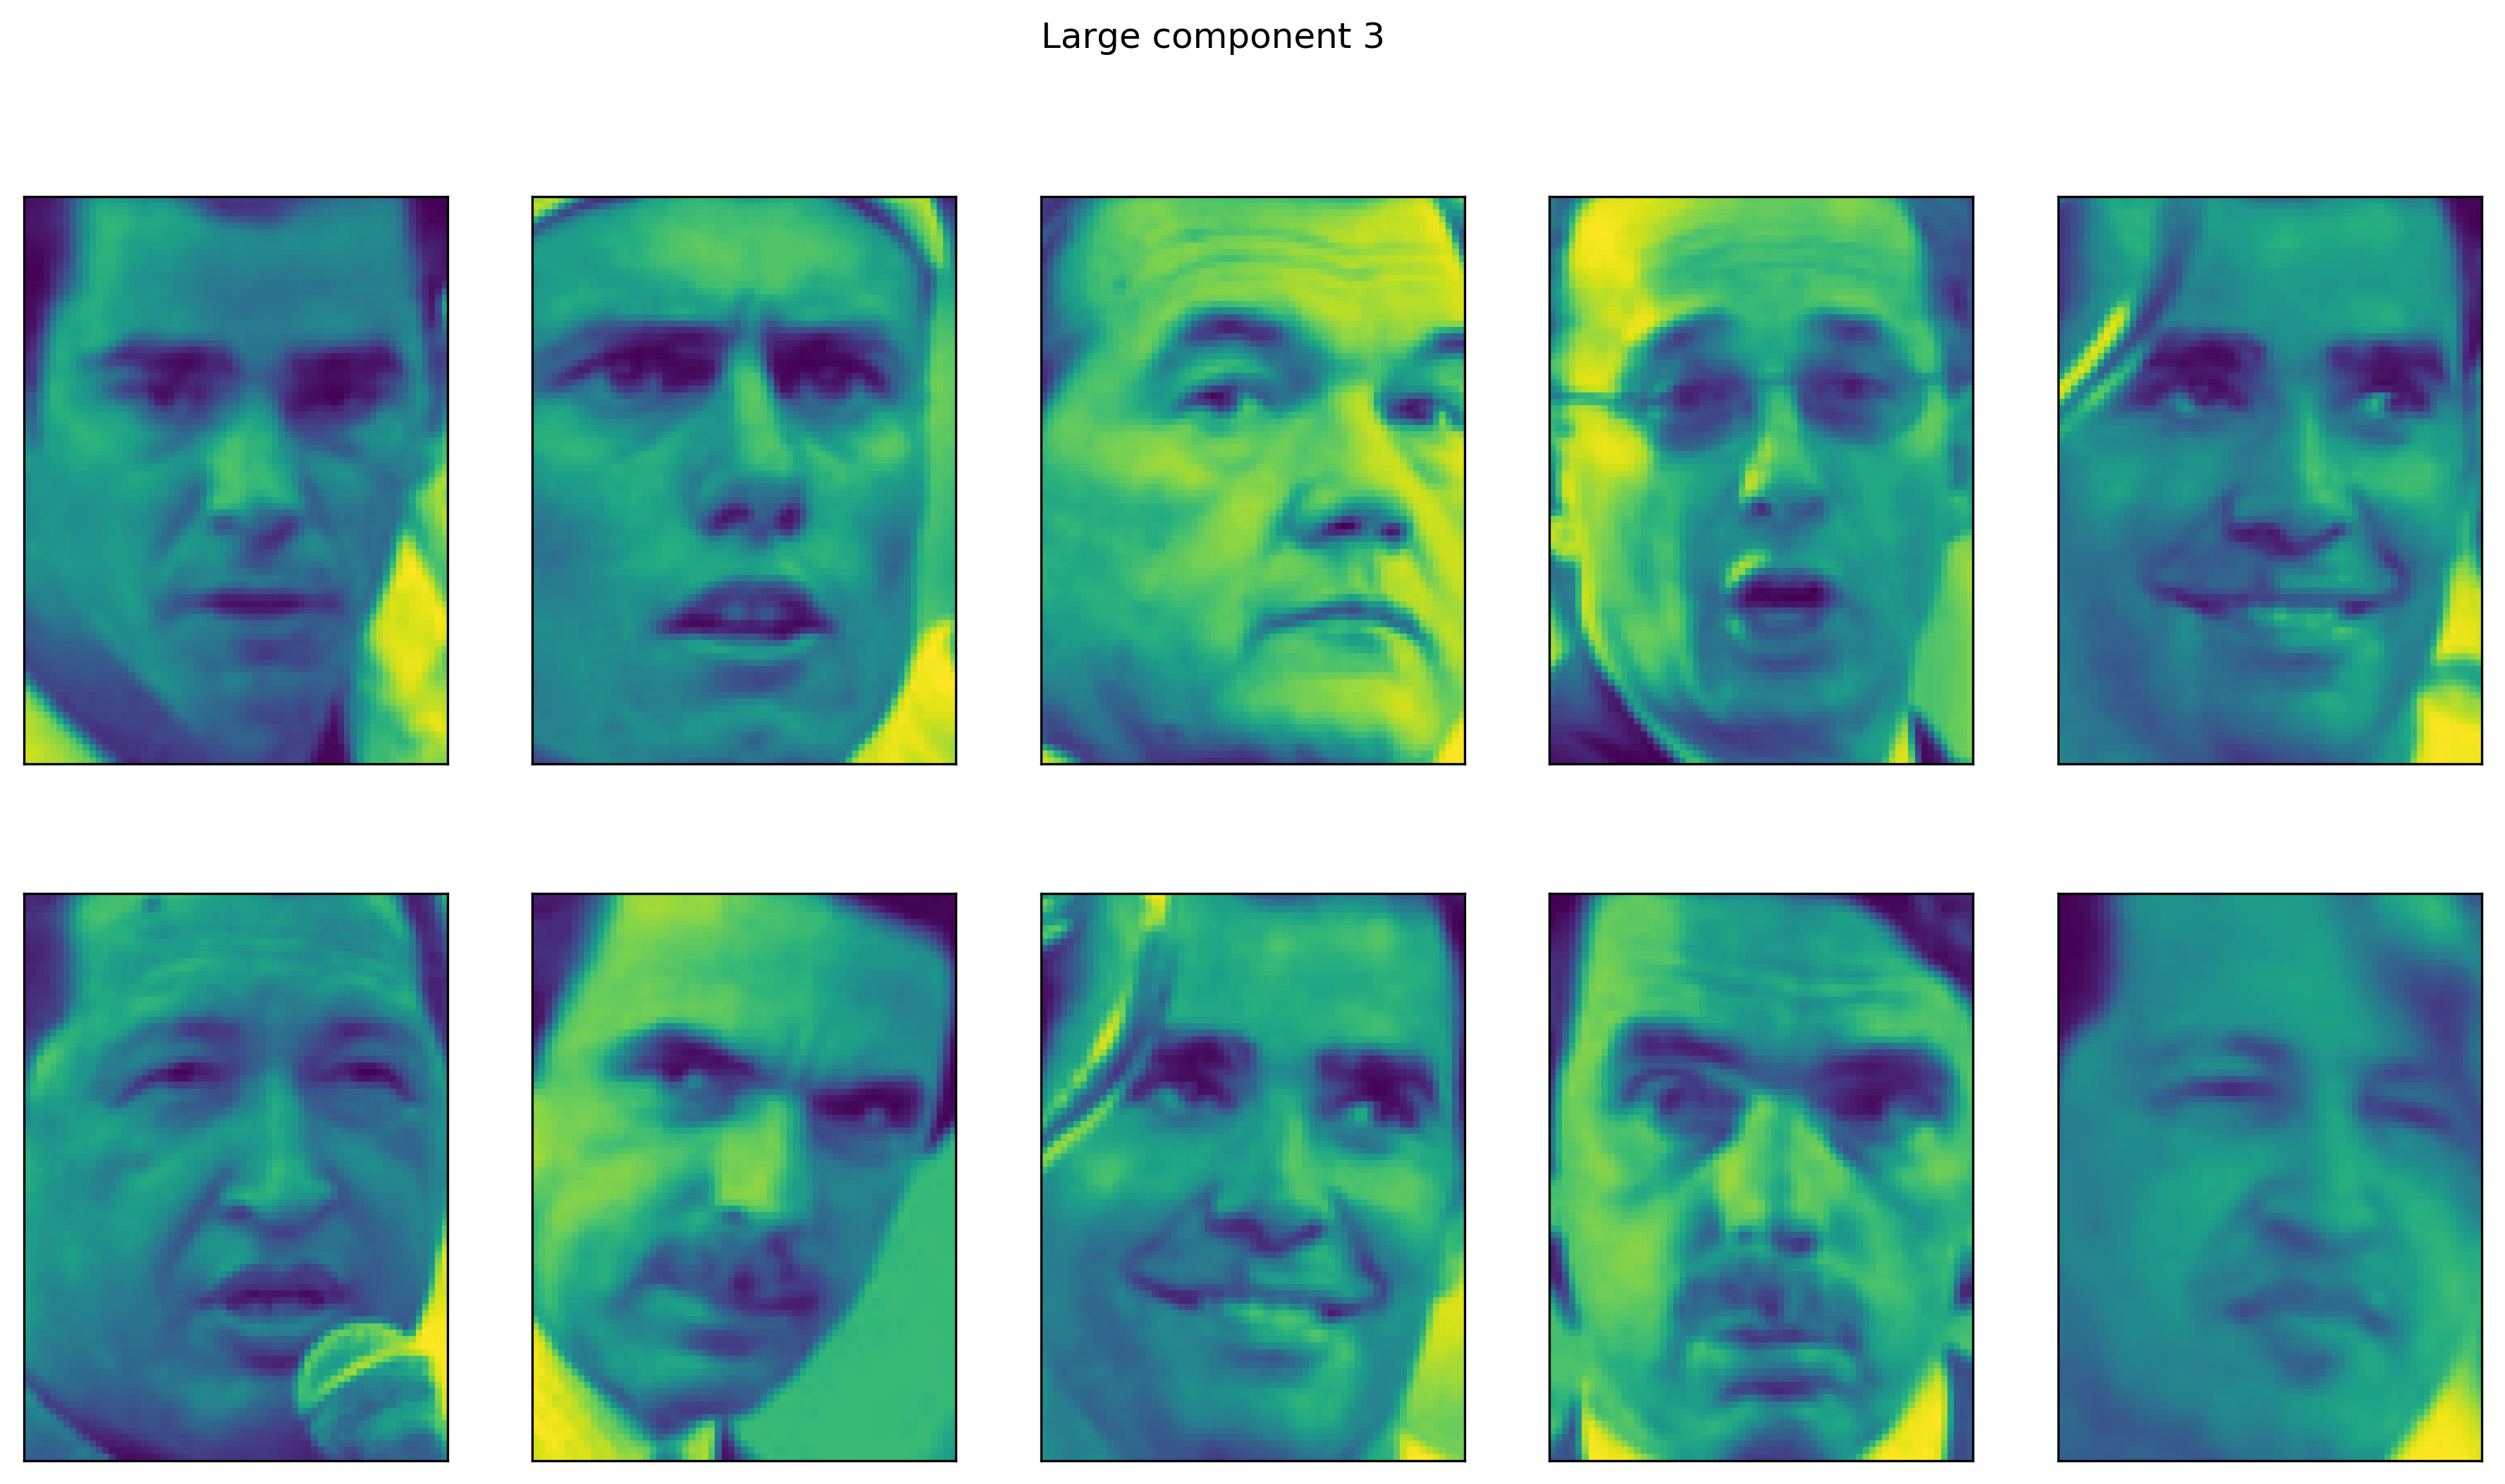

In [15]:
compn = 3
# sort by 3rd component, plot first 10 images
inds = np.argsort(X_train_nmf[:, compn])[::-1]
fig, axes = plt.subplots(2, 5, figsize=(15, 8), subplot_kw={'xticks': (), 'yticks': ()})
fig.suptitle("Large component 3")
for i, (ind, ax) in enumerate(zip(inds, axes.ravel())):
    ax.imshow(X_train[ind].reshape(image_shape))

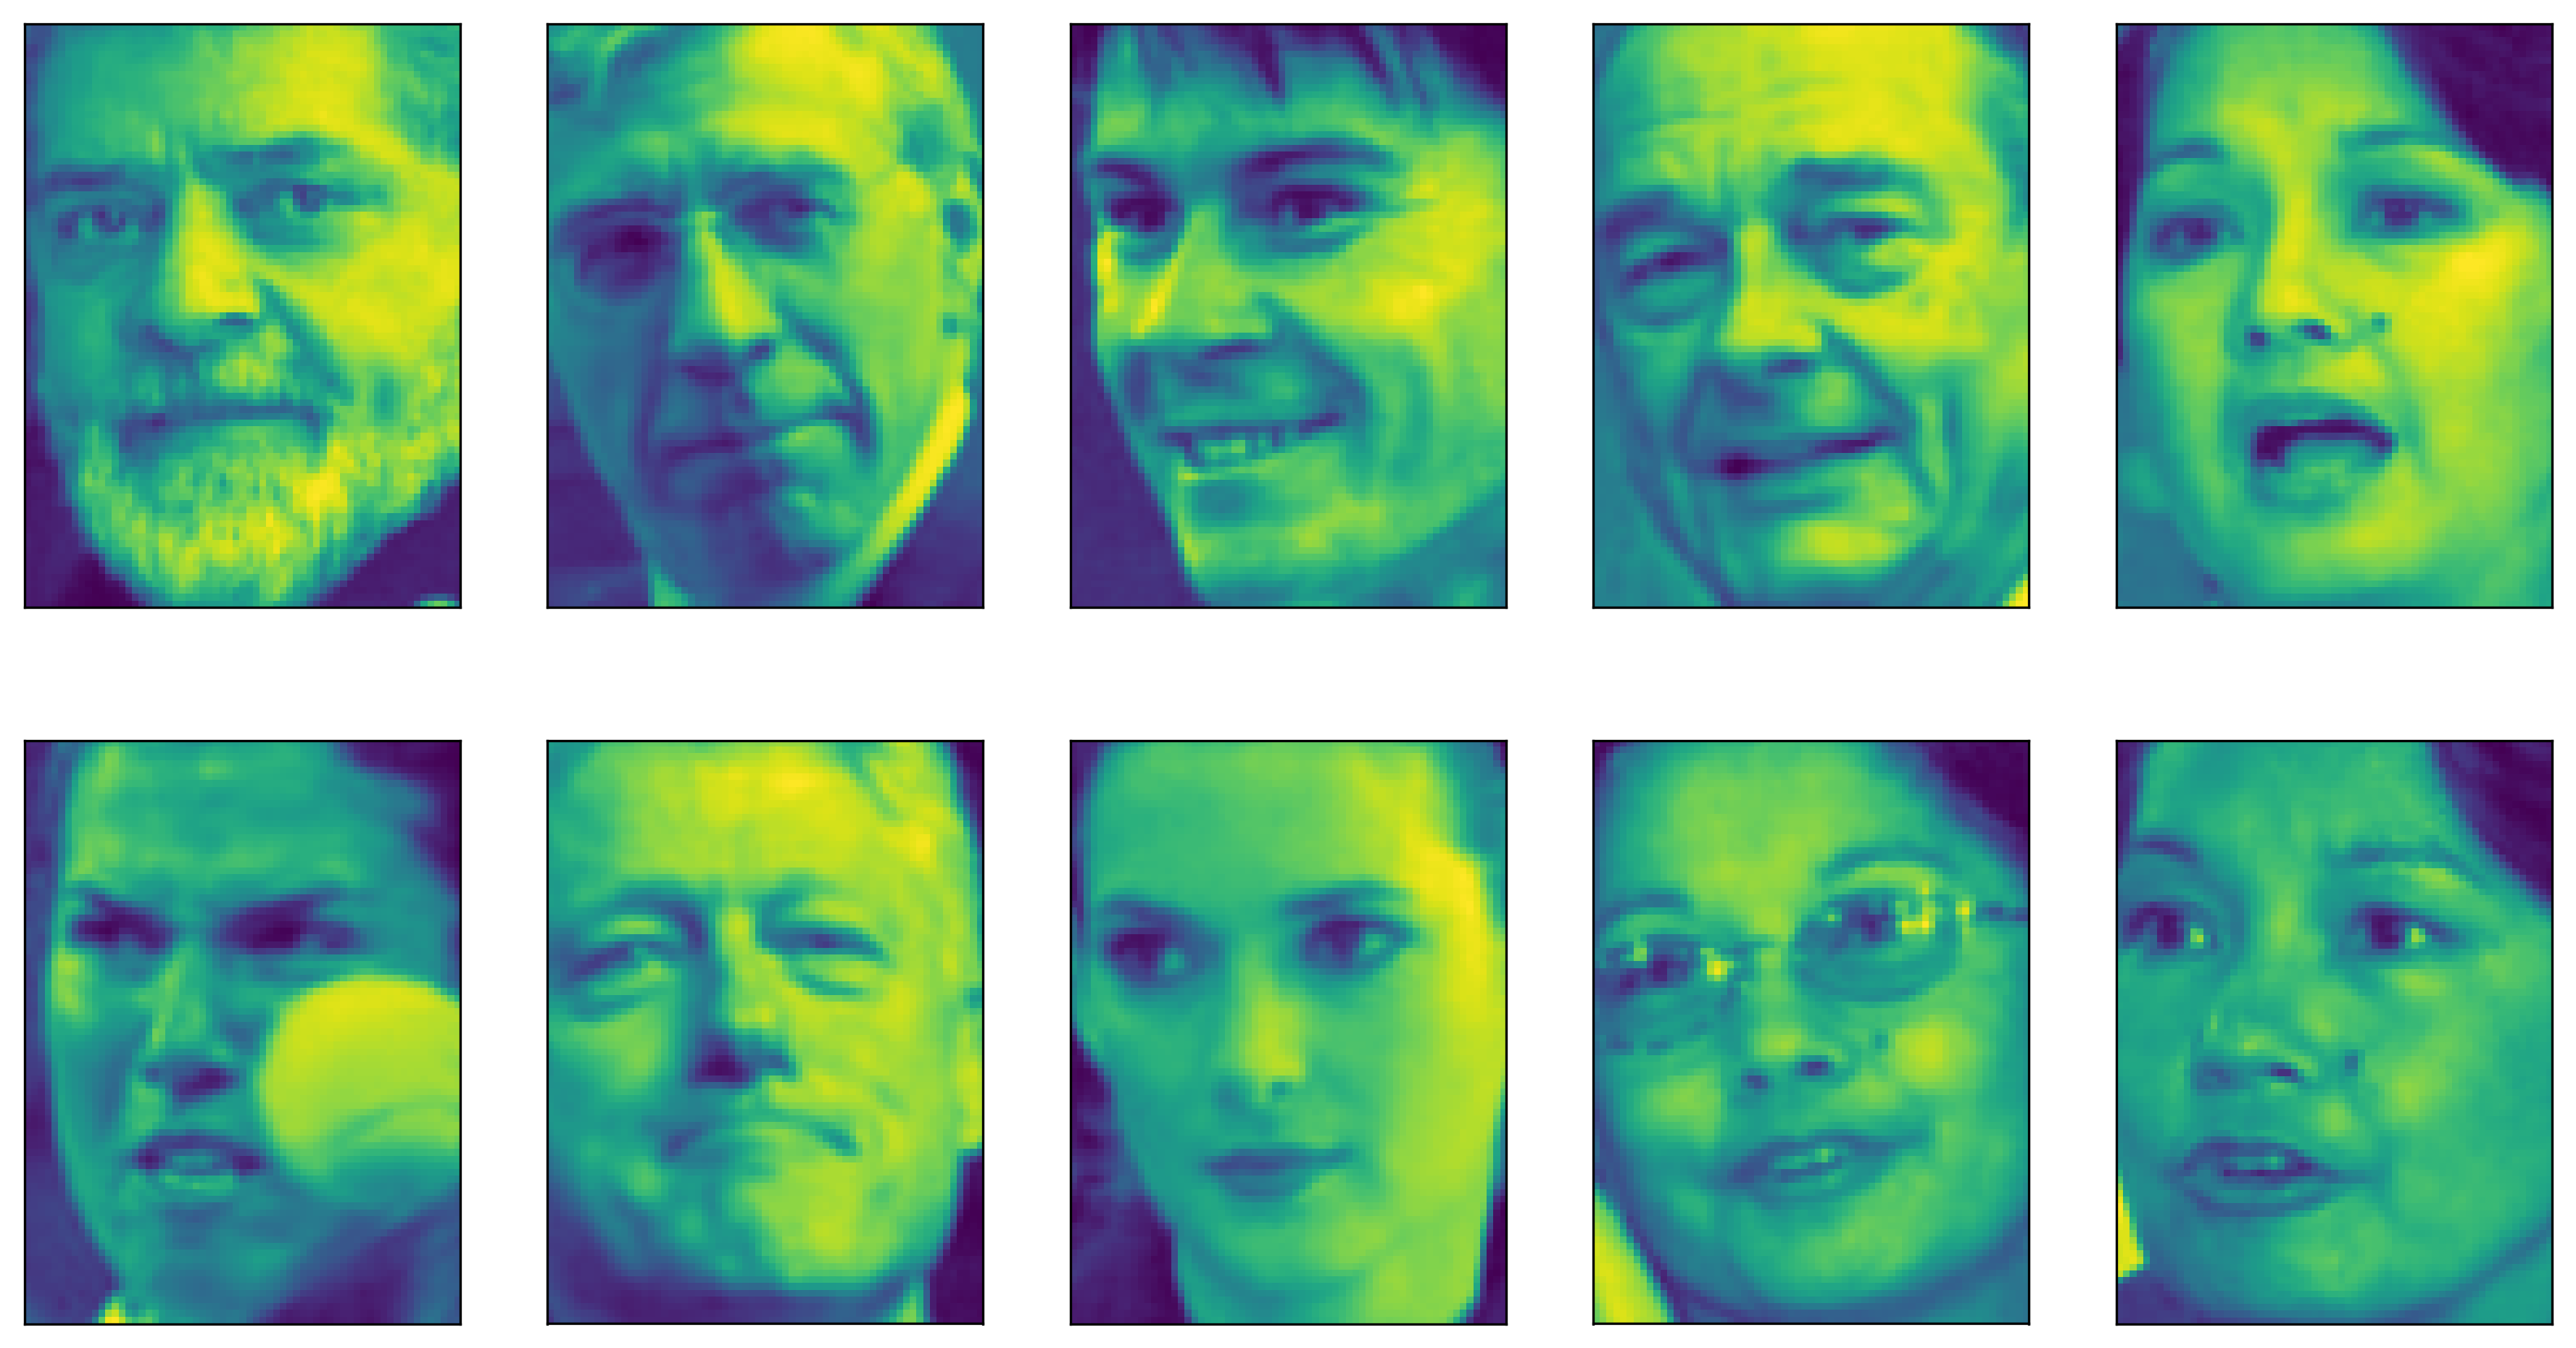

In [16]:
compn = 7
# sort by 7th component, plot first 10 images
inds = np.argsort(X_train_nmf[:, compn])[::-1]
fig.suptitle("Large component 7")
fig, axes = plt.subplots(2, 5, figsize=(15, 8), subplot_kw={'xticks': (), 'yticks': ()})
for i, (ind, ax) in enumerate(zip(inds, axes.ravel())):
    ax.imshow(X_train[ind].reshape(image_shape))

Shape of S: (2000, 3)


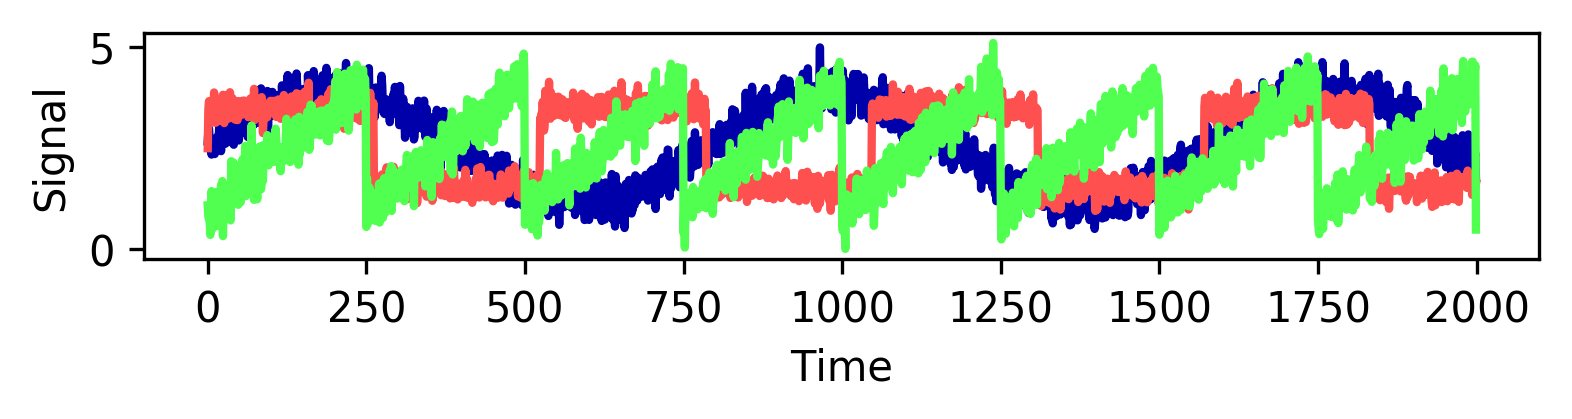

In [17]:
S = mglearn.datasets.make_signals()
print("Shape of S: {}".format(S.shape))
plt.figure(figsize=(6, 1))
plt.plot(S, '-')
plt.xlabel("Time")
plt.ylabel("Signal")

Shape of measurements: (2000, 100)


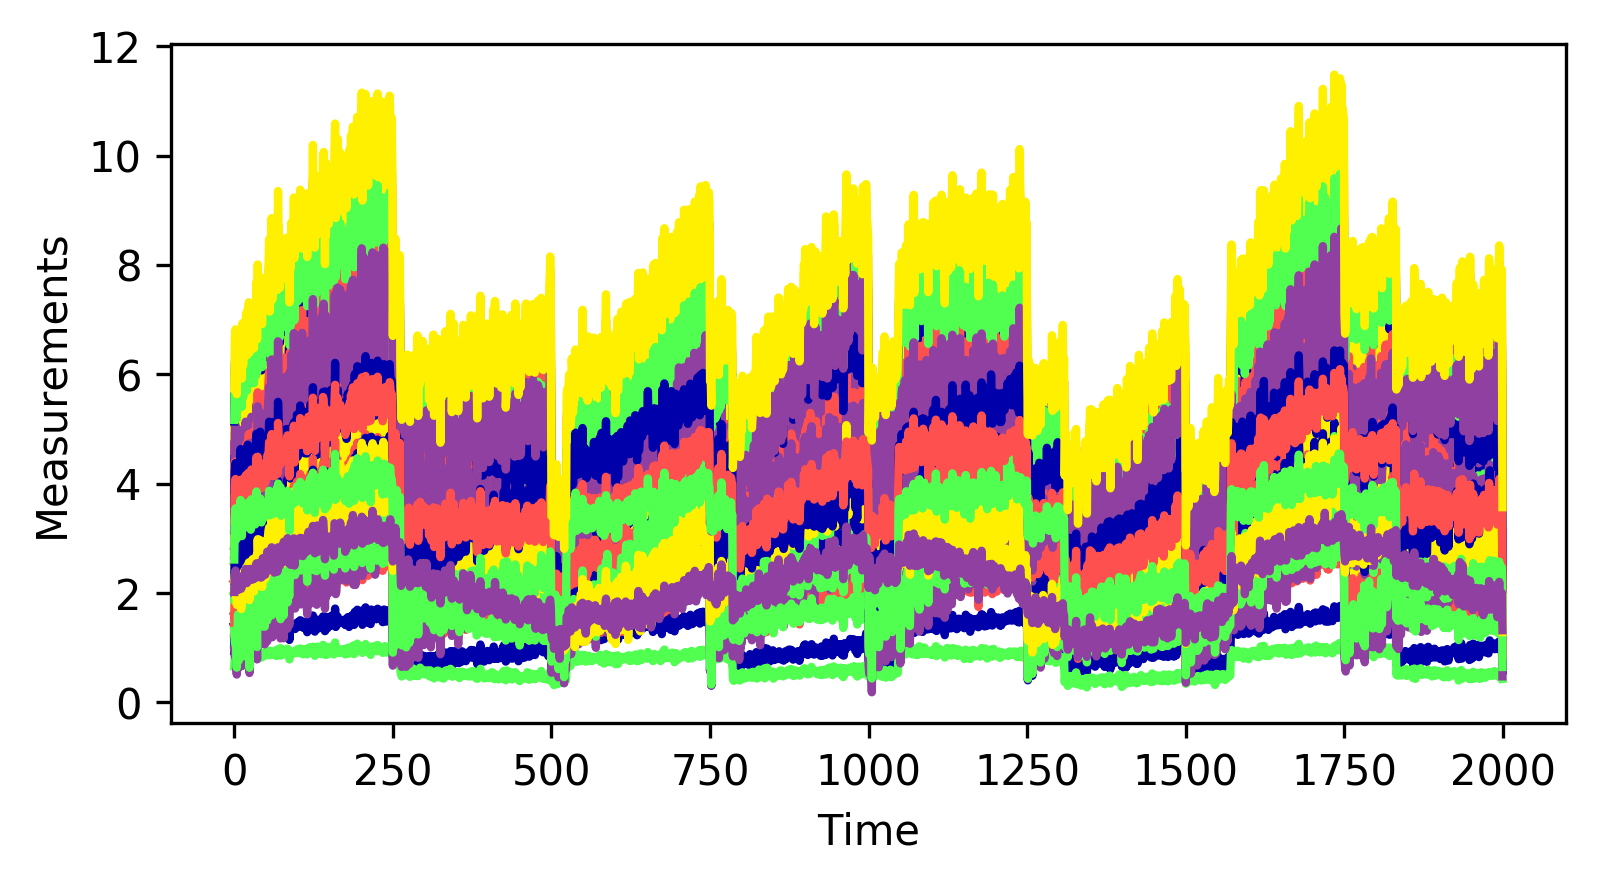

In [18]:
# Mix data into a 100 dimensional state
A = np.random.RandomState(0).uniform(size=(100, 3))
X = np.dot(S, A.T)
print("Shape of measurements: {}".format(X.shape))
plt.figure(figsize=(6, 3))
plt.plot(X, '-')
plt.xlabel("Time")
plt.ylabel("Measurements")

In [19]:
nmf = NMF(n_components=3, random_state=42)
S_ = nmf.fit_transform(X)
print("NMF - Recovered signal shape: {}".format(S_.shape))

NMF - Recovered signal shape: (2000, 3)


In [21]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
H = pca.fit_transform(X)
print("PCA - Recovered signal shape: {}".format(H.shape))

PCA - Recovered signal shape: (2000, 3)


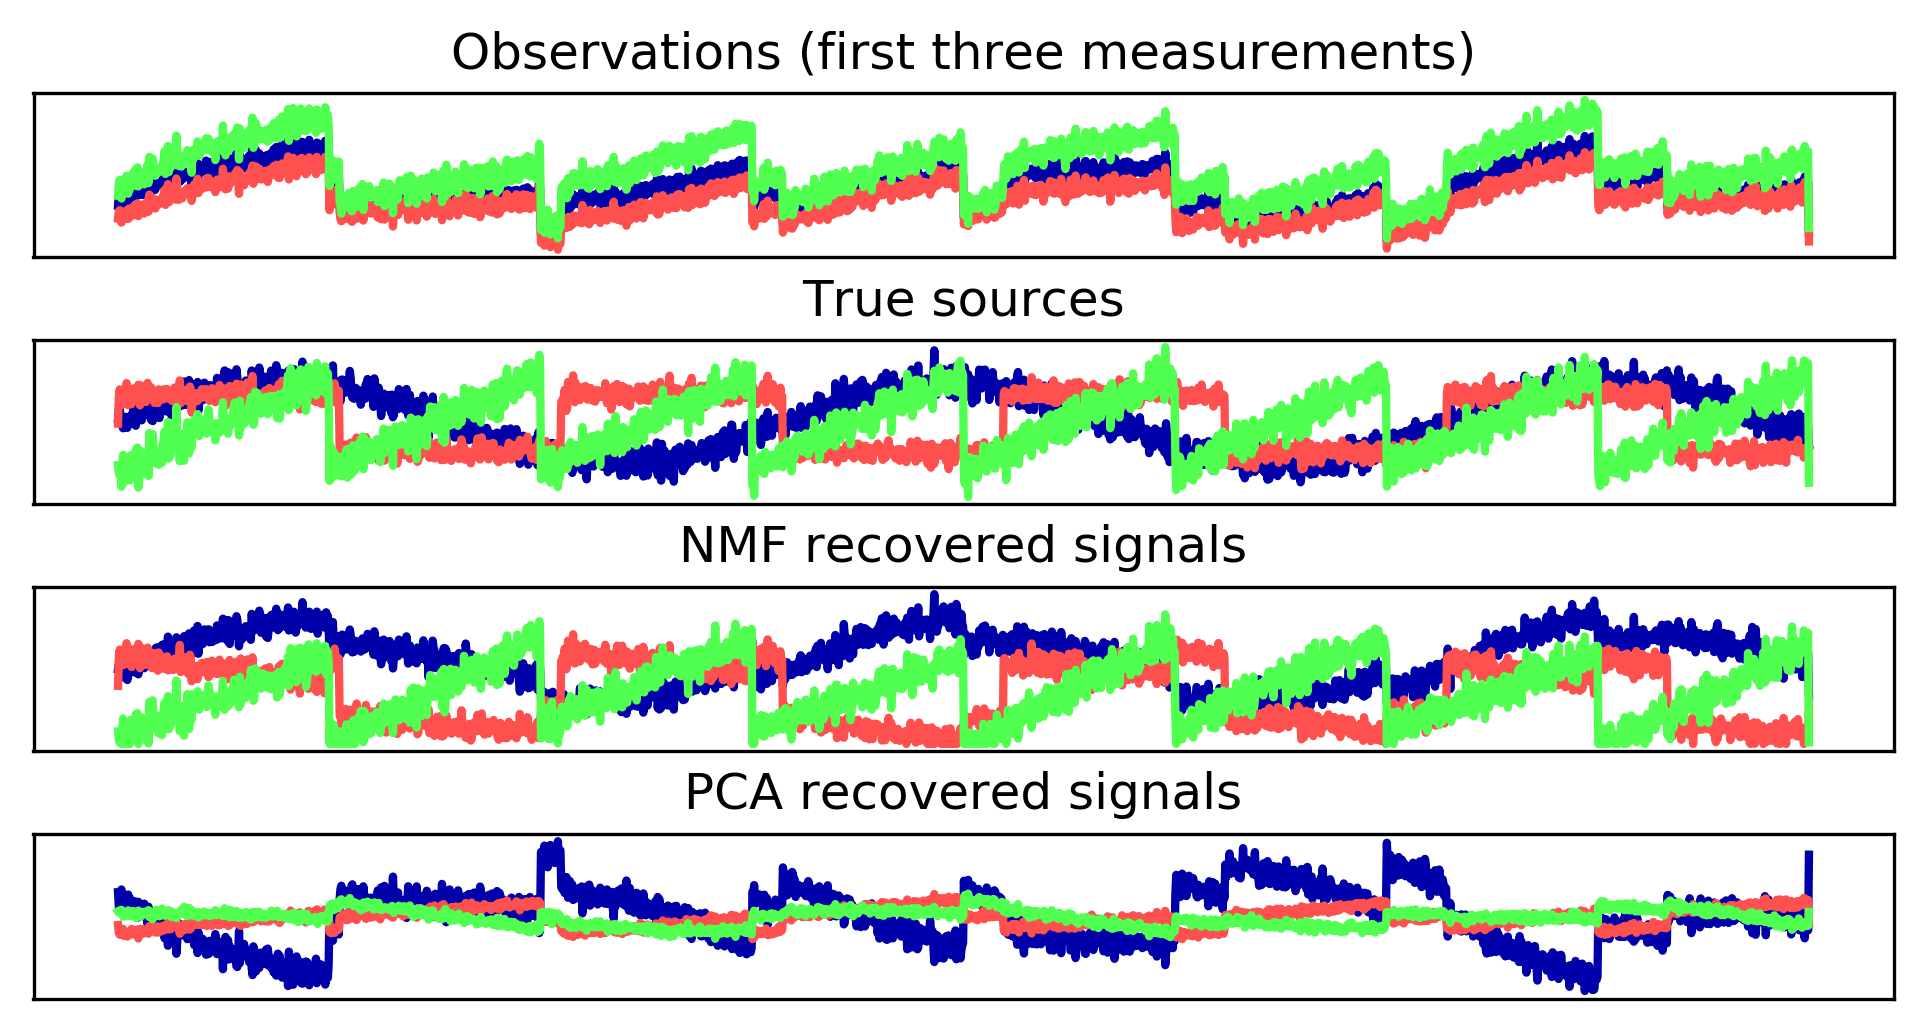

In [22]:
models = [X, S, S_, H]
names = ['Observations (first three measurements)',
         'True sources',
         'NMF recovered signals',
         'PCA recovered signals']

fig, axes = plt.subplots(4, figsize=(8, 4), gridspec_kw={'hspace': .5}, subplot_kw={'xticks': (), 'yticks': ()})

for model, name, ax in zip(models, names, axes):
    ax.set_title(name)
    ax.plot(model[:, :3], '-')